# Import Library

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import pickle
import matplotlib.image as mping
from math import *
import os
%matplotlib inline

In [2]:
# Loading camera calibration
mtx, dist, rvecs, tvecs = pickle.load( open('./cameraCalibration.pickle', 'rb' ))

In [3]:
def showImages(images, cols = 2, rows = 4, figsize=(15,15), colorspace='rgb', showOriginal=False):
    """
    Display `images` on a [`cols`, `rows`] subplot grid.
    """
    imgLength = len(images)
    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    indexes = range(cols * rows)
    for ax, index in zip(axes.flat, indexes):
        if index < imgLength:
            imagePathName, img = images[index]
#             print(img.shape)
            if len(img.shape) == 3:
                # color space conversion
                if colorspace == 'gray':
                    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                elif colorspace == 'hsv':
                    img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
                elif colorspace == 'hls':
                    img = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
                elif colorspace == 'lab':
                    img = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
                elif colorspace == 'luv':
                    img = cv2.cvtColor(img, cv2.COLOR_BGR2LUV)
                elif colorspace == 'yuv':
                    img = cv2.cvtColor(img, cv2.COLOR_BGR2YUV)
                else:
                    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 
            
            if showOriginal:
                ax.imshow(img)
            else:
                ax.imshow(img, cmap='gray')
            ax.set_title(imagePathName)

def save_output(outFolder, output_images):
    if not os.path.exists(outFolder):
        os.makedirs(outFolder)
    for imagePath, img in output_images:
        imgName = imagePath.split('.')[1].split('/')[2]+'_output.jpg' 
        outFile = '%s/%s' % (outFolder, imgName)
        cv2.imwrite(outFile, img)

# Image Undistort Function

In [4]:
def imgUndistort(img, mtx=mtx, dist=dist):
    """
    Undistort image
    
    Arguments:
        img: source image
        mtx: camera internal matrix
        dist: distortion coefficients
    """
    return cv2.undistort(img, mtx, dist, None, mtx)

# Input/Test Images

In [5]:
# Load test images.
testImages = list(map(lambda imageFileName: (imageFileName, cv2.imread(imageFileName)), 
                      glob.glob('./test_images/*.jpg')))

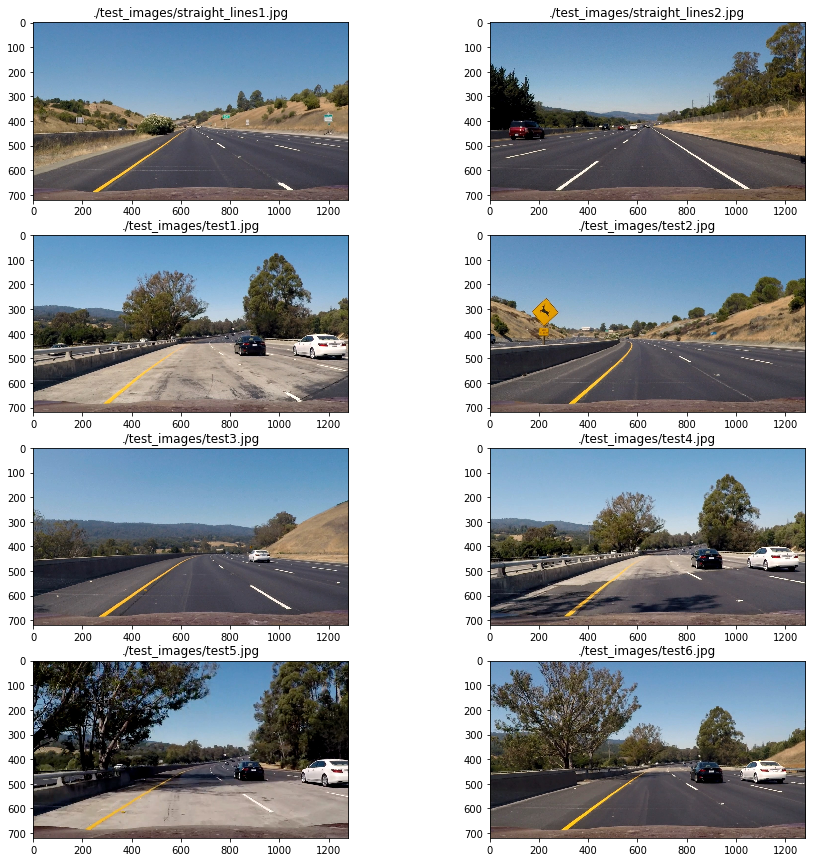

In [6]:
showImages(testImages, showOriginal=True)

# Apply Undistort Function

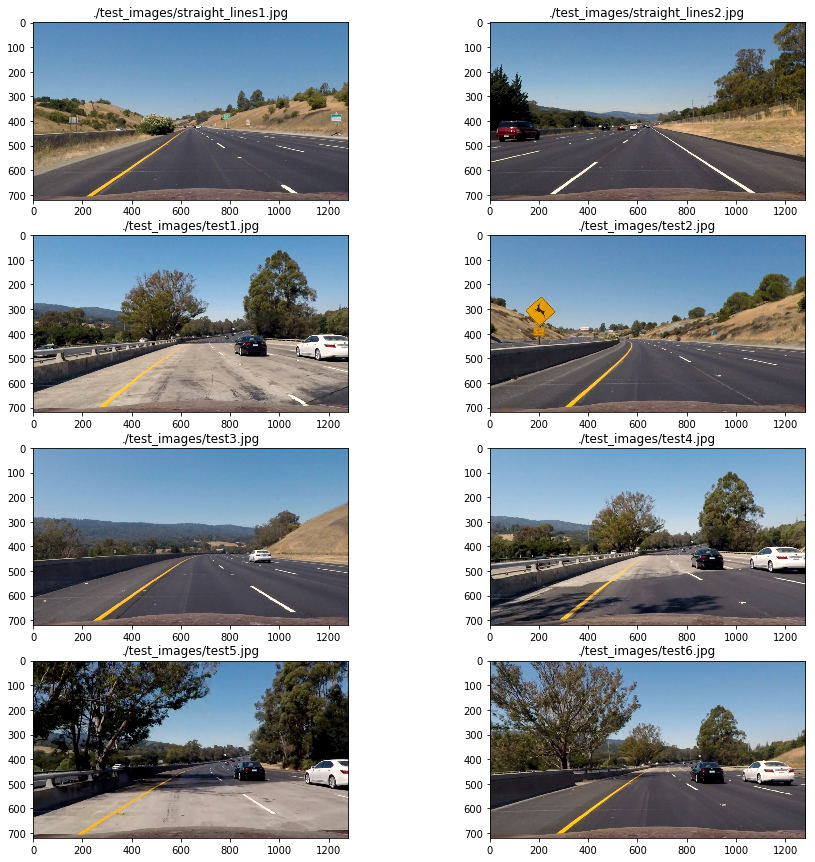

In [7]:
undistort_images = list(map(lambda image: (image[0], imgUndistort(image[1])), testImages))
showImages(undistort_images)
save_output('output_images/undistort', undistort_images)

# Let's see how each color channel outputs

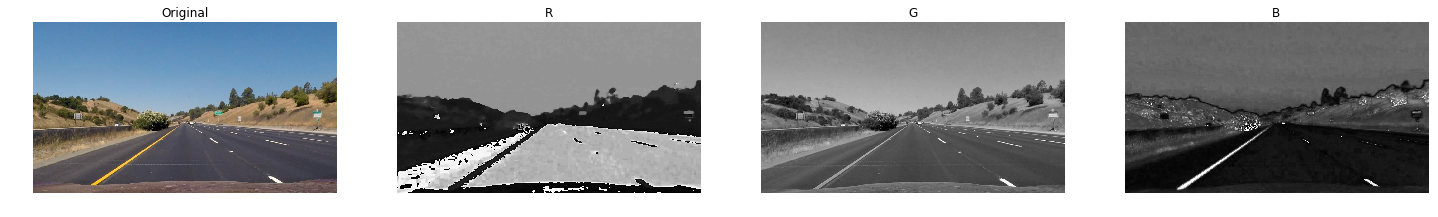

In [8]:
undist = cv2.undistort(testImages[0][1], mtx, dist, None, mtx)
hlsOriginal = cv2.cvtColor(undist, cv2.COLOR_BGR2HLS)


fig, axes = plt.subplots(ncols=4, figsize=(25,10))
titles = ['Original', 'R', 'G', 'B']
for index, a in enumerate(axes):
    if index == 0:
        a.imshow(cv2.cvtColor(testImages[0][1], cv2.COLOR_BGR2RGB))
    else:
        a.imshow(hlsOriginal[:,:,index-1], cmap='gray')
    a.axis('off')
    a.set_title(titles[index])

# Color transforms and gradients to create a thresholded binary image

In [9]:
def makeBinaryImage(img, mag_threshold=(0,255), dir_threshold=(0.7, 1.3), mode='simple', sobel_kernel=3):
    '''
    Returns a binary image based on the following inputs
    - threshold
    - threshold mode
    '''
    binary = np.zeros_like(img)
    if mode == 'sobelX':
        sobelX_abs = np.absolute(cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=sobel_kernel))
        scaled_sobelX = np.uint8(255*sobelX_abs/np.max(sobelX_abs))
        binary[(scaled_sobelX >= mag_threshold[0]) & (scaled_sobelX <= mag_threshold[1])] = 1
    elif mode == 'sobelY':
        sobelY_abs = np.absolute(cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=sobel_kernel))
        scaled_sobelY = np.uint8(255*sobelY_abs/np.max(sobelY_abs))
        binary[(scaled_sobelY >= mag_threshold[0]) & (scaled_sobelY <= mag_threshold[1])] = 1
    elif mode == 'magnitude':
        sobelX = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
        sobelY = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
        # calculate the magnitude
        sobel_mag = np.sqrt(np.square(sobelX) + np.square(sobelY))
        # scale to 8-bit (0 - 255) and convert to type = np.uint8
        sobel_scale = np.uint8(255*sobel_mag/np.max(sobel_mag))
        # create a binary mask where mag thresholds are met
        binary[(sobel_scale >= mag_threshold[0]) & (sobel_scale <= mag_threshold[1])] = 1
    elif mode == 'direction':
        sobelX_abs = np.absolute(cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=sobel_kernel))
        scaled_sobelX = np.uint8(255*sobelX_abs/np.max(sobelX_abs))
        sobelY_abs = np.absolute(cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=sobel_kernel))
        scaled_sobelY = np.uint8(255*sobelY_abs/np.max(sobelY_abs))
        # use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
        gradients = np.arctan2(scaled_sobelY, scaled_sobelX)
        binary[(gradients >= dir_threshold[0]) & (gradients <= dir_threshold[1])] = 1
    elif mode == 'mag_dir_combined':
        # Take the gradient in x and y separately
        sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=9) 
        sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=9)

        # Calculate the magnitude of gradient
        gradmag = np.sqrt(sobelx**2 + sobely**2)
        
        # Scale to 8-bit (0 - 255) and convert to type = np.uint8
        scaled_sobel = np.uint8(255*gradmag / np.max(gradmag))

        #Calculate angle
        abs_sobelx = np.absolute(sobelx)
        abs_sobely = np.absolute(sobely)
        absgraddir = np.arctan2(abs_sobely, abs_sobelx) 

        # Create a binary mask where mag thresholds are met
        binary = np.zeros_like(scaled_sobel)
        binary[(scaled_sobel >= mag_threshold[0]) & \
                      (scaled_sobel <= mag_threshold[1]) & \
                      (absgraddir >= dir_threshold[0])   & \
                      (absgraddir <= dir_threshold[1])] = 1
    elif mode == 'mag_color_combined':
        sx_thresh=(20, 50)
        s_thresh=(170, 255)
        l_thresh=(40, 255)
        # Convert to HLS color space and separate the L and S
        hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        l_channel = hls[:,:,1]
        s_channel = hls[:,:,2]
        # Sobel x
        sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
        abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
        scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))

        # Threshold x gradient
        sxbinary = np.zeros_like(scaled_sobel)
        sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1

        # Threshold color channel
        s_binary = np.zeros_like(s_channel)
        s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
        
        # Threshold lightness
        l_binary = np.zeros_like(l_channel)
        l_binary[(l_channel >= l_thresh[0]) & (l_channel <= l_thresh[1])] = 1
        
        # Stack each channel
        channels = 255*np.dstack(( l_binary, sxbinary, s_binary)).astype('uint8')        
        binary = np.zeros_like(sxbinary)
        binary[((l_binary == 1) & (s_binary == 1) | (sxbinary==1))] = 1
        binary = 255*np.dstack((binary,binary,binary)).astype('uint8')
    elif mode == 'hls_s_channel':
        hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        s_channel = hls[:,:,2]
        binary[(s_channel > mag_threshold[0]) & (s_channel <= mag_threshold[1])] = 1
    elif mode == 'laplacian_s_channel_combined':
        hls = cv2.cvtColor(img.astype(np.uint8), cv2.COLOR_RGB2HLS)
        gray = (0.5*img[:,:,0] + 0.4*img[:,:,1] + 0.1*img[:,:,2]).astype(np.uint8)
        s = hls[:,:,2]

        _, gray_binary = cv2.threshold(gray.astype('uint8'), 150, 255, cv2.THRESH_BINARY)

        total_px = img.shape[0]*img.shape[1]
        laplacian = cv2.Laplacian(gray, cv2.CV_32F, ksize=21)
        mask_three = (laplacian < 0.15*np.min(laplacian)).astype(np.uint8)
        if cv2.countNonZero(mask_three)/total_px < 0.01:
            laplacian = cv2.Laplacian(gray, cv2.CV_32F, ksize=21)
            mask_three = (laplacian < 0.075*np.min(laplacian)).astype(np.uint8)

        _, s_binary = cv2.threshold(s.astype('uint8'), 150, 255, cv2.THRESH_BINARY)
        mask_two = s_binary

        binary = np.clip(cv2.bitwise_and(gray_binary, 
                            cv2.bitwise_or(mask_three, mask_two)), 0, 1).astype('uint8')
        binary[:ceil(img.shape[0]//2)] = 0
    else:
        binary[(img >= mag_threshold[0]) & (img <= mag_threshold[1])] = 1  
    return binary

In [75]:
# def find_edges(image, ksize = 11, mask_half=False):
    
#     hls = cv2.cvtColor(image.astype(np.uint8), cv2.COLOR_RGB2HLS)
#     gray = (0.5*image[:,:,0] + 0.4*image[:,:,1] + 0.1*image[:,:,2]).astype(np.uint8)
#     s = hls[:,:,2]
    
#     _, gray_binary = cv2.threshold(gray.astype('uint8'), 150, 255, cv2.THRESH_BINARY)

#     total_px = image.shape[0]*image.shape[1]
#     laplacian = cv2.Laplacian(gray, cv2.CV_32F, ksize=21)
#     mask_three = (laplacian < 0.15*np.min(laplacian)).astype(np.uint8)
#     if cv2.countNonZero(mask_three)/total_px < 0.01:
#         laplacian = cv2.Laplacian(gray, cv2.CV_32F, ksize=21)
#         mask_three = (laplacian < 0.075*np.min(laplacian)).astype(np.uint8)

#     _, s_binary = cv2.threshold(s.astype('uint8'), 150, 255, cv2.THRESH_BINARY)
#     mask_two = s_binary

#     combined_binary = np.clip(cv2.bitwise_and(gray_binary, 
#                         cv2.bitwise_or(mask_three, mask_two)), 0, 1).astype('uint8')

#     # Mask out top half of image to reduce distractions
#     # Only used when unwarped image is passed in
#     if mask_half:
#         combined_binary[:ceil(image.shape[0]//2)] = 0

#     return combined_binary

In [65]:
# combined_binary = find_edges(cv2.cvtColor(testImages[0][1], cv2.COLOR_BGR2RGB), mask_half=True)
# plt.imshow(combined_binary, cmap='gray')

In [66]:
# combined_binary_images = list(map(lambda image: (image[0], find_edges(cv2.cvtColor(image[1], cv2.COLOR_BGR2RGB), mask_half=True)), testImages))
# showImages(combined_binary_images, colorspace='gray')
                     

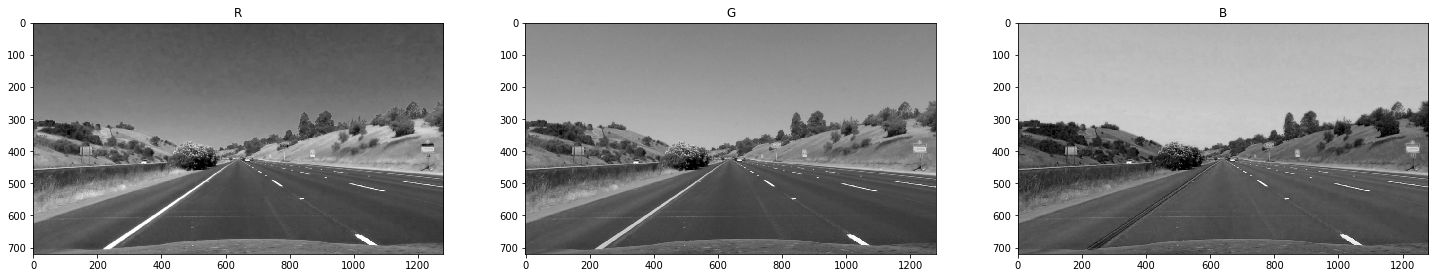

In [10]:
fig, axes = plt.subplots(ncols=3, figsize=(25,10))
for index, ax in enumerate(axes):
    ax.imshow(cv2.cvtColor(undistort_images[0][1], cv2.COLOR_BGR2RGB)[:, :, index], cmap='gray')
    ax.set_title(titles[index+1])

In [11]:
def applyAndShow(images, mag_threshold=(0,255), dir_threshold=(0.7,1.3), sobel_kernel=3, action='simple'):
    """
    Applies `action` to the pair collection `images` (`title`, image) show the images and titles and return
    (`title`, `action`(image))
    """
    output = list(map(lambda img: (img[0], makeBinaryImage(cv2.cvtColor(img[1], cv2.COLOR_BGR2RGB), mag_threshold, dir_threshold, action, sobel_kernel)), images))
    showImages( output, colorspace='gray')
    return output

# Magnitude Gradient Output

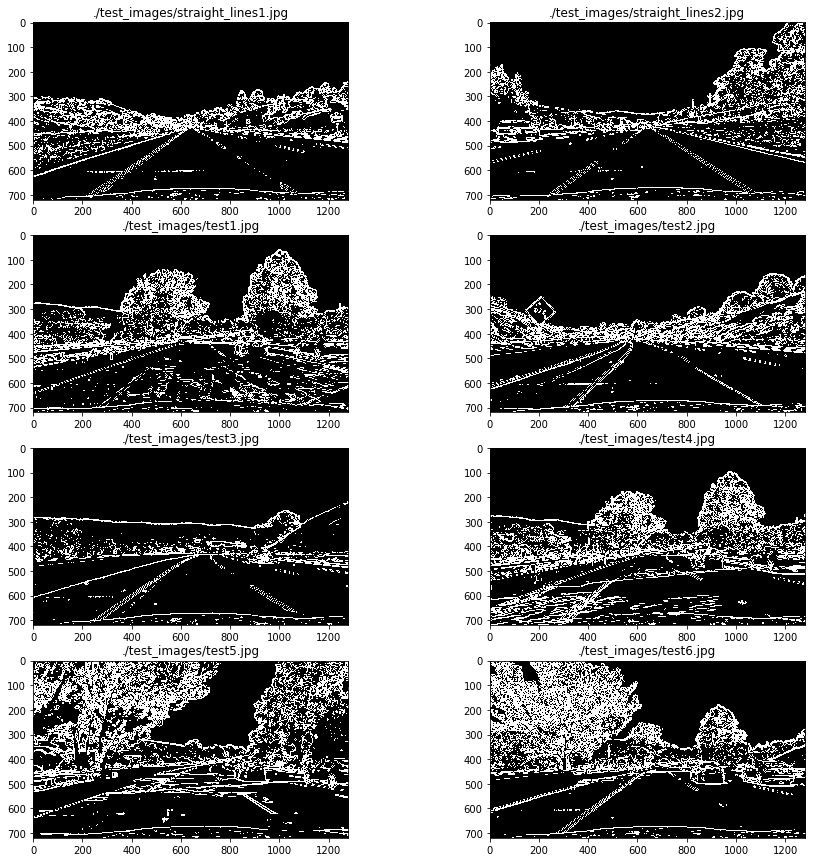

In [12]:
mag_binary_output = applyAndShow(undistort_images, mag_threshold=(20,100), sobel_kernel=9, action='magnitude')

# Direction of Gradient

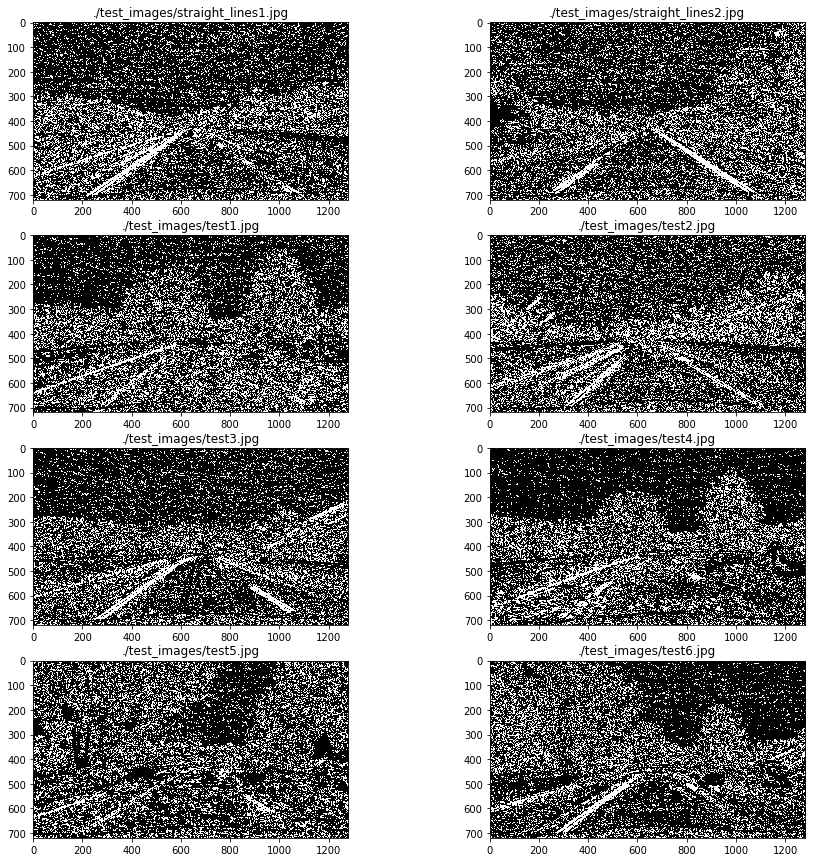

In [78]:
dir_binary_output = applyAndShow(undistort_images, dir_threshold=(0.7, 1.3), sobel_kernel=15, action='direction')

# Magnitude and Direction gradient combination

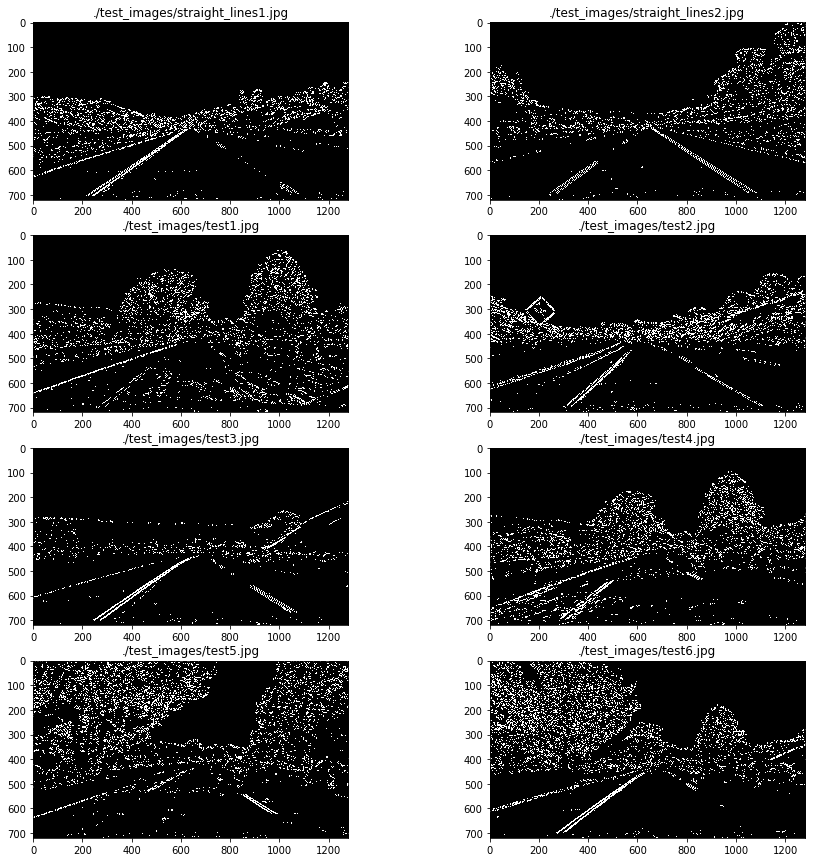

In [79]:
mag_dir_binary_output = applyAndShow(undistort_images, mag_threshold=(20,150), dir_threshold=(0.7,1.3), action='mag_dir_combined')

# HLS S channel Binary

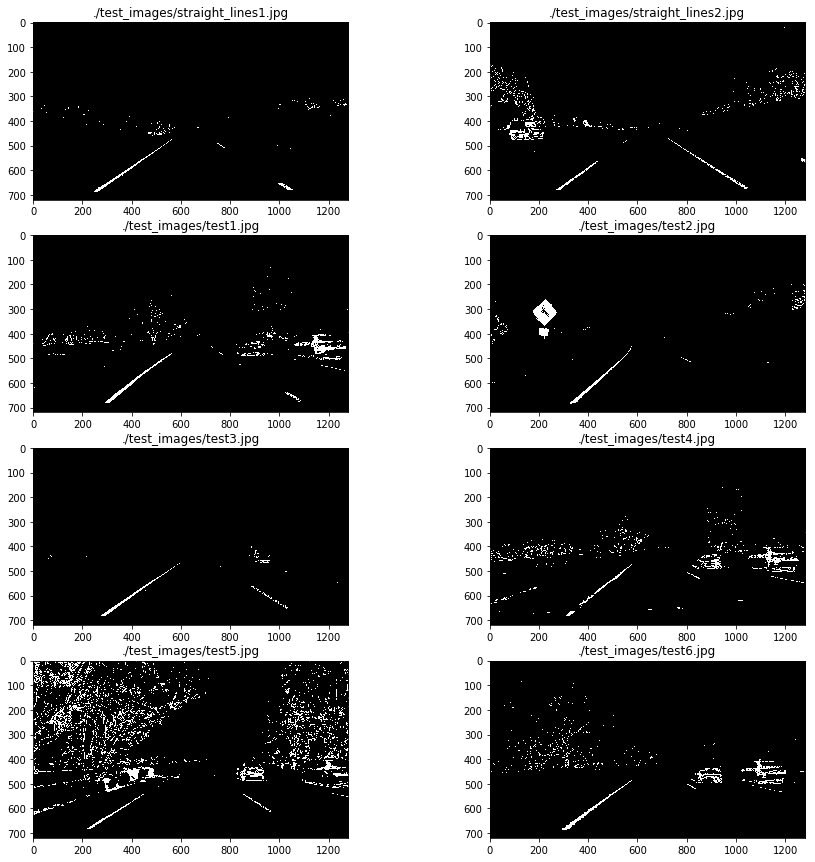

In [80]:
hls_binary_output = applyAndShow(testImages,  mag_threshold=(190,255), action='hls_s_channel')

# Magnitude and Color combination

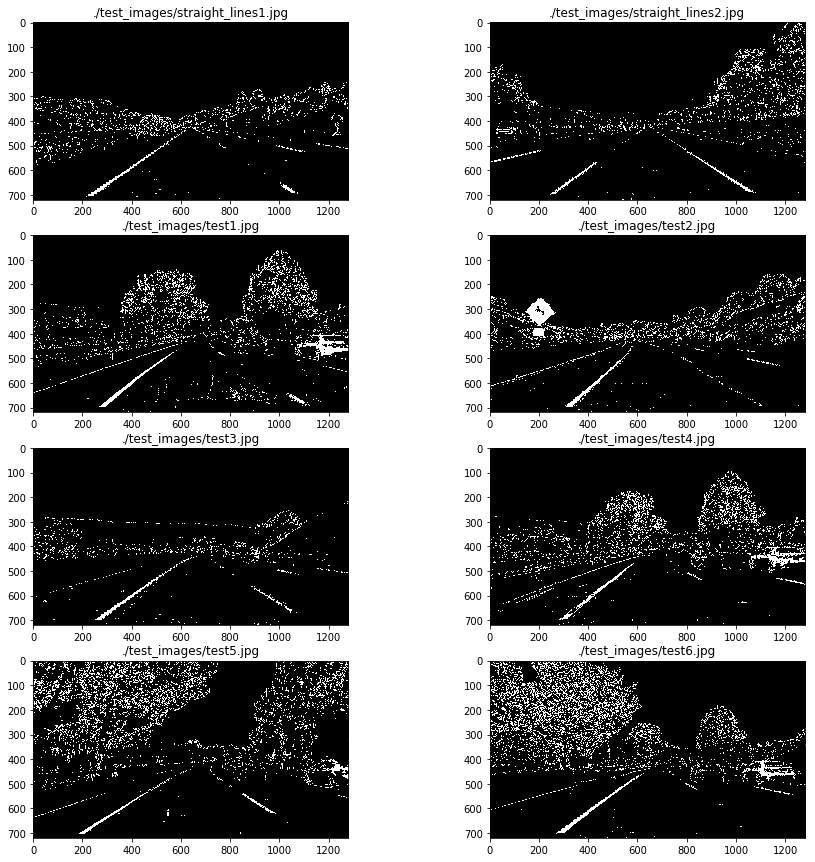

In [81]:
mag_color_binary_output = applyAndShow(undistort_images, action='mag_color_combined')

# Laplacian and HLS s-channel Combination

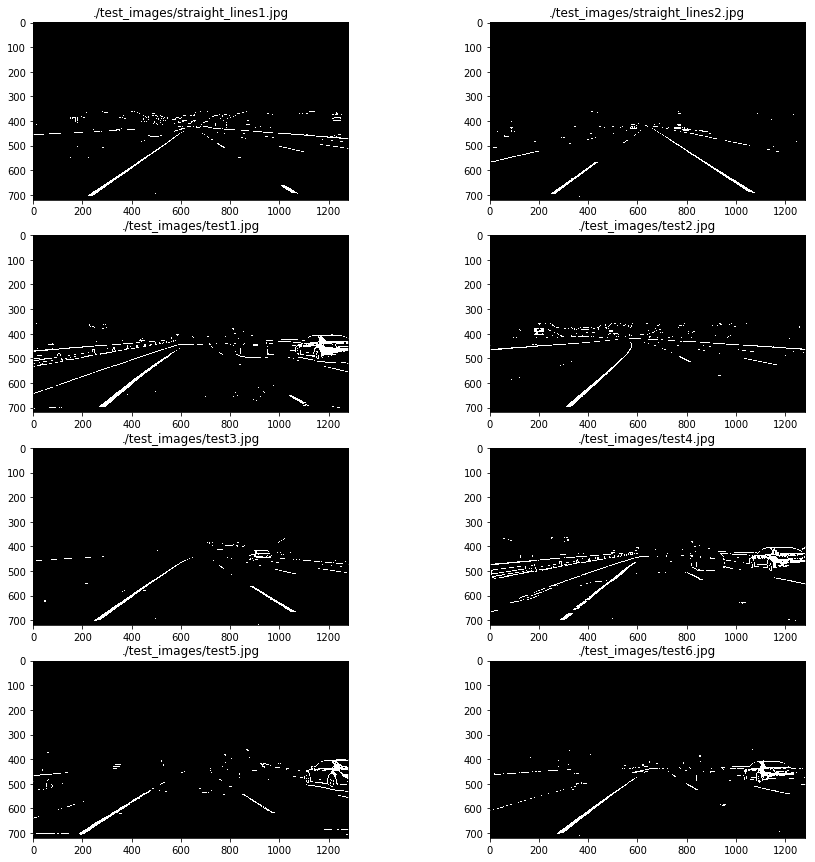

In [13]:
laplacian_binary_output = applyAndShow(undistort_images, action='laplacian_s_channel_combined')

# Perspective Transform

In [14]:
def perspective_transform_matrix(img, show_debug=False):
    img_size = img.shape[:2][::-1]
#     print(img_size)
    src = np.float32(\
    [[(img_size[0] / 2) - 75, img_size[1] / 2 + 110],\
     [((img_size[0] / 6) - 10), img_size[1]],\
     [(img_size[0] * 5 / 6) + 60, img_size[1]],\
     [(img_size[0] / 2 + 75), img_size[1] / 2 + 110]]) 

    dst = np.float32(\
    [[(img_size[0] / 4), 0],\
     [(img_size[0] / 4), img_size[1]],\
     [(img_size[0] * 3 / 4), img_size[1]],\
     [(img_size[0] * 3 / 4), 0]])
    
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    
    if show_debug == True:
        print("source points")
        print(src)
        print("Transformed points")
        print(dst)

        plt.figure(figsize=(16, 16))
        plt.subplot(1, 2, 1)
        plt.imshow(img) 
        plt.plot(src[:,0], src[:,1], 'rx')
        plt.title('Original Image')

        plt.subplot(1, 2, 2)
        warped = cv2.warpPerspective(img, M, img_size)
        plt.imshow(warped) 
        plt.plot(dst[:,0], dst[:,1], 'rx')
        plt.title('Perspective Transformed Image')
    
    return M, Minv

# Test perspective transform and debug the src and destination points

source points
[[  565.           470.        ]
 [  203.33332825   720.        ]
 [ 1126.66662598   720.        ]
 [  715.           470.        ]]
Transformed points
[[ 320.    0.]
 [ 320.  720.]
 [ 960.  720.]
 [ 960.    0.]]


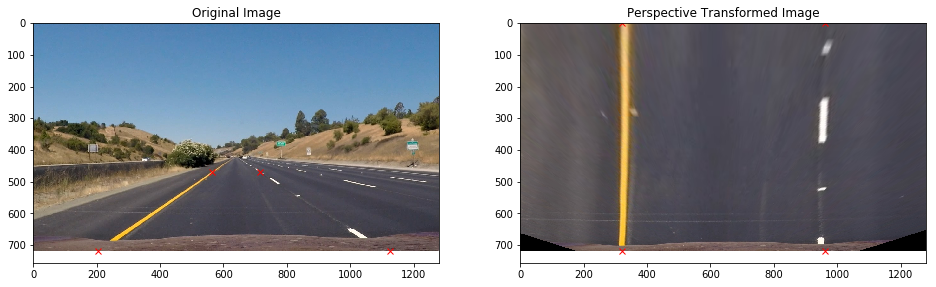

In [15]:
testImage = mping.imread('test_images/straight_lines1.jpg')

M, Minv = perspective_transform_matrix(testImage, show_debug=True)

# Warping the image using perspective transform output

In [16]:
def warpImage(img):
    img_size = img.shape[:2][::-1]
    M, Minv = perspective_transform_matrix(img)
    return cv2.warpPerspective(img, M, img_size)

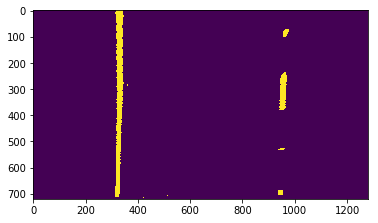

In [17]:
plt.imshow(warpImage(laplacian_binary_output[0][1]))

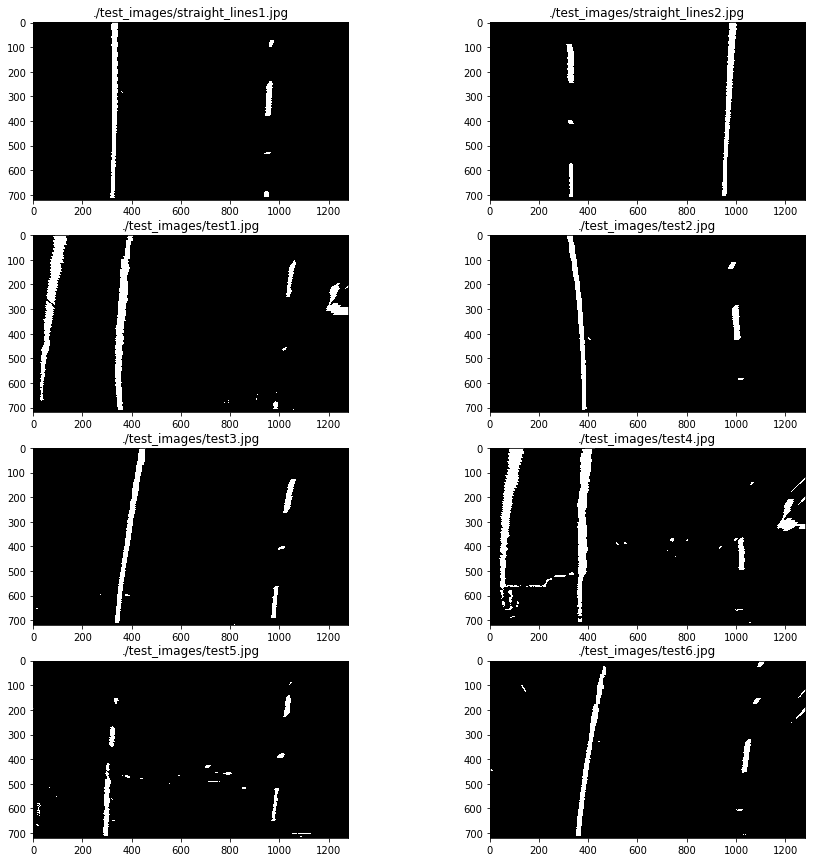

In [18]:
warped_images = list(map(lambda img: (img[0], warpImage(img[1])), laplacian_binary_output))

showImages(warped_images)

# Lane histogram peaks

In [19]:
def show_histogram(binary_image):   
    histogram = np.sum(binary_image[binary_image.shape[0]//2:, :], axis=0)
    plt.plot(histogram)

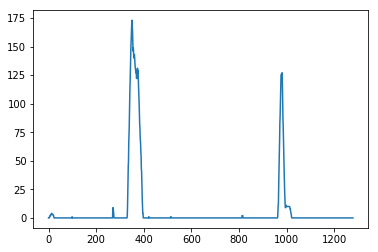

In [20]:
show_histogram(warped_images[4][1])

# Finding lanes using sliding windows

In [21]:
def find_lane_pixels(binary_warped, nwindows=9, margin=100, minpix=50, bias=0.2):
    """
    margin: Set the width of the windows +/- margin
    minpix: Set minimum number of pixels found to recenter window
    bias: left start and right start offest from middpoint
    """
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    
    leftstart = int((1-bias)*midpoint)
    rightstart = int((1+bias)*midpoint)
    
    leftx_base = np.argmax(histogram[:leftstart])
    rightx_base = np.argmax(histogram[rightstart:]) + rightstart

    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])

    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base

    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 4) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 4) 
        
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)

        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255] 
    
    left_fit = None
    right_fit = None
    
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    
    # Fit a second order polynomial to each
    if len(leftx) != 0:
        left_fit = np.polyfit(lefty, leftx, 2)
        p_left = np.poly1d(left_fit)
        left_fitx = p_left(ploty)
        left_line_pts = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
        cv2.polylines(out_img, np.int_(left_line_pts), isClosed=False, color=(255,255,0), thickness=5)
        
    if len(rightx) != 0:
        right_fit = np.polyfit(righty, rightx, 2)
        p_right = np.poly1d(right_fit)
        right_fitx = p_right(ploty)   
        right_line_pts = np.array([np.transpose(np.vstack([right_fitx, ploty]))])
        cv2.polylines(out_img, np.int_(right_line_pts), isClosed=False, color=(255,255,0), thickness=5)
    
    return out_img, left_fit, right_fit

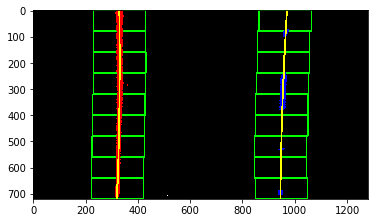

In [22]:
out_img, left_fit, right_fit = find_lane_pixels(warped_images[0][1])
plt.imshow(out_img)
# print(left_fit)

In [23]:
fit_lane_images = list(map(lambda img: (img[0], find_lane_pixels(img[1])[0]), warped_images))
left_fits = list(map(lambda img: find_lane_pixels(img[1])[1], warped_images))
right_fits = list(map(lambda img: find_lane_pixels(img[1])[2], warped_images))

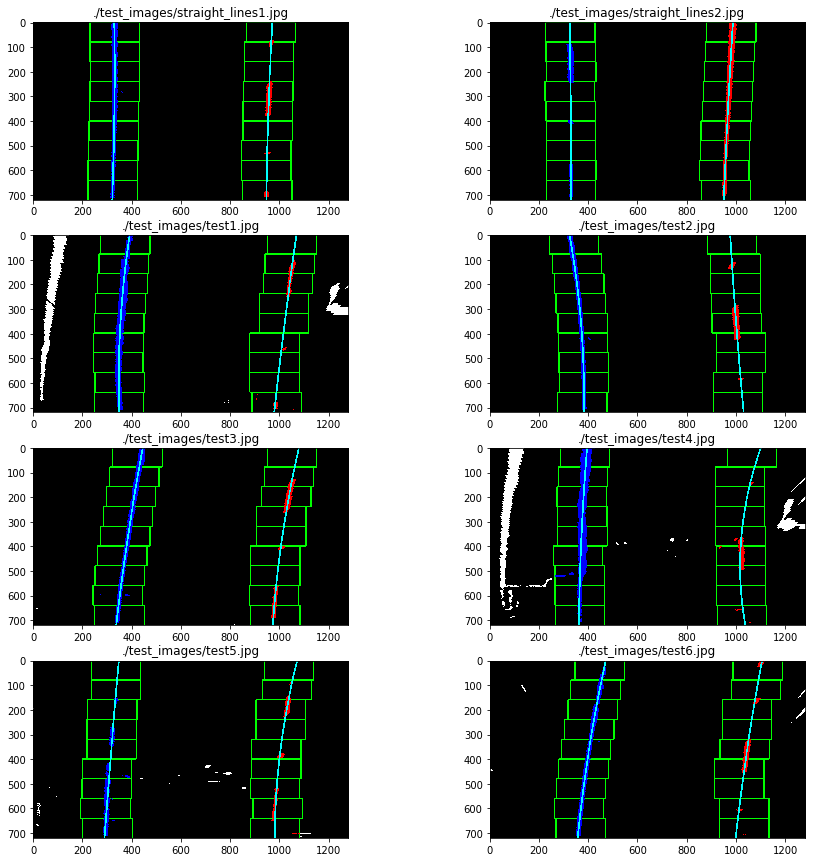

In [24]:
showImages(fit_lane_images)

# Finding lanes from previous fit line

In [25]:
def fitted_lanes(binary_warped, left_fit, right_fit, margin = 100, minpix = 50):
    # Assume you now have a new warped binary image 
    # from the next frame of video (also called "binary_warped")
    # It's now much easier to find line pixels!
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])

    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
    left_fit[1]*nonzeroy + left_fit[2] + margin))) 

    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
    right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    
    left_new_fit = None
    right_new_fit = None
    
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    # Fit a second order polynomial to each
    p_left = np.poly1d(left_fit)
    left_fitx = p_left(ploty)
        
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                                  ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    
    p_right = np.poly1d(right_fit)
    right_fitx = p_right(ploty) 
        
     # Generate a polygon to illustrate the search window area
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                                  ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
        
    
    if len(leftx) != 0:
        left_new_fit = np.polyfit(lefty, leftx, 2)
        p_left = np.poly1d(left_new_fit)
        left_fitx = p_left(ploty)
        # Generate a polygon to illustrate the search window area
        # And recast the x and y points into usable format for cv2.fillPoly()

        left_line_pts = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
        cv2.polylines(out_img, np.int_(left_line_pts), isClosed=False, color=(255,255,0), thickness=5)
            
    if len(rightx) != 0:
        right_new_fit = np.polyfit(righty, rightx, 2)
        p_right = np.poly1d(right_new_fit)
        right_fitx = p_right(ploty)  
        
      
        right_line_pts = np.array([np.transpose(np.vstack([right_fitx, ploty]))])
        cv2.polylines(out_img, np.int_(right_line_pts), isClosed=False, color=(255,255,0), thickness=5)
    
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
    return result,left_new_fit,right_new_fit

## Sample

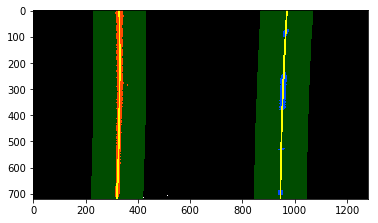

In [26]:
out_img1, left_fit, right_fit = fitted_lanes(warped_images[0][1], left_fits[0], right_fits[0])
plt.imshow(out_img1)

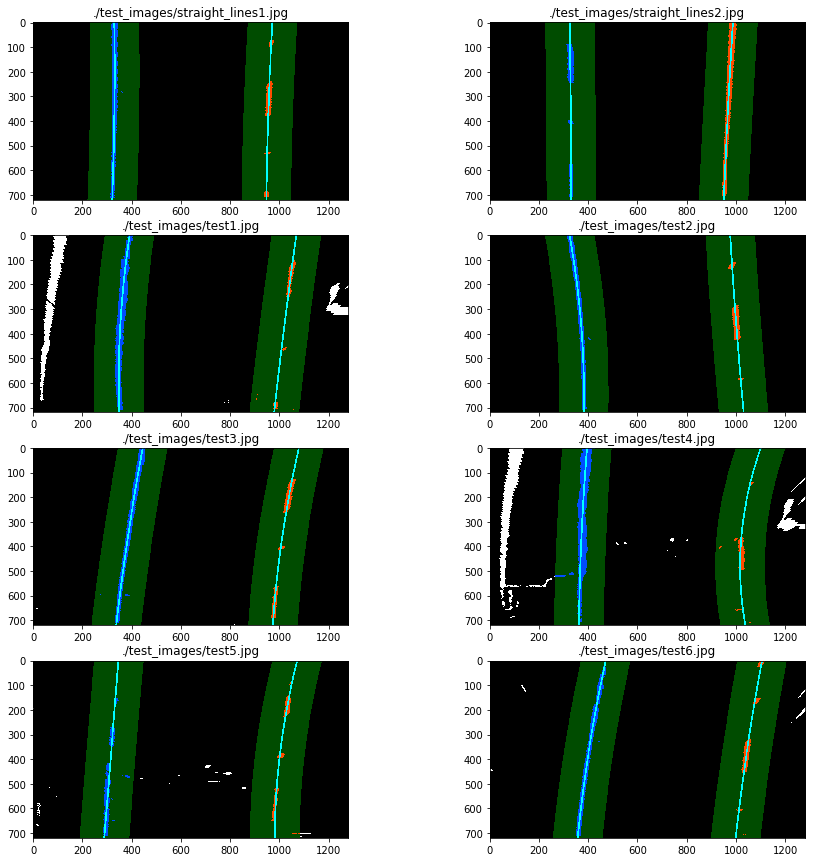

In [27]:
recogin_images = list(map(lambda iImg: (iImg[1][0], fitted_lanes(iImg[1][1], left_fits[iImg[0]], right_fits[iImg[0]])[0]), enumerate(warped_images)))
left_fits = list(map(lambda iImg: fitted_lanes(iImg[1][1], left_fits[iImg[0]], right_fits[iImg[0]])[1], enumerate(warped_images)))
right_fits = list(map(lambda iImg: fitted_lanes(iImg[1][1], left_fits[iImg[0]], right_fits[iImg[0]])[2], enumerate(warped_images)))

showImages(recogin_images)

# It's time to Warp image back to original image

In [28]:
def unwarp(img, left_fit, right_fit):
#     print(img.shape)
    img_size = img.shape[:2][::-1]
    
    M, Minv = perspective_transform_matrix(img)
    
    if left_fit.any() != None and right_fit.any() != None:    
        color_warp = np.zeros_like(img).astype(np.uint8)

        ploty = np.linspace(0, img.shape[0]-1, img.shape[0] )
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

        # Recast the x and y points into usable format for cv2.fillPoly()
        pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
        pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
        pts = np.hstack((pts_left, pts_right))

        # Draw the lane onto the warped blank image
        cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

        # Warp the blank back to original image space using inverse perspective matrix (Minv)
        newwarp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0])) 
        # Combine the result with the original image
        result = cv2.addWeighted(img, 1, newwarp, 0.3, 0)
    else:
        result = img
    
    return result

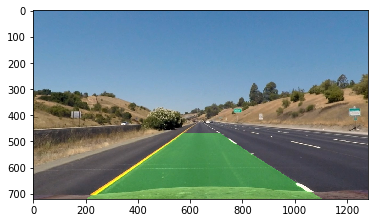

In [29]:
plt.imshow(unwarp(cv2.cvtColor(undistort_images[0][1], cv2.COLOR_BGR2RGB), left_fits[0], right_fits[0]))

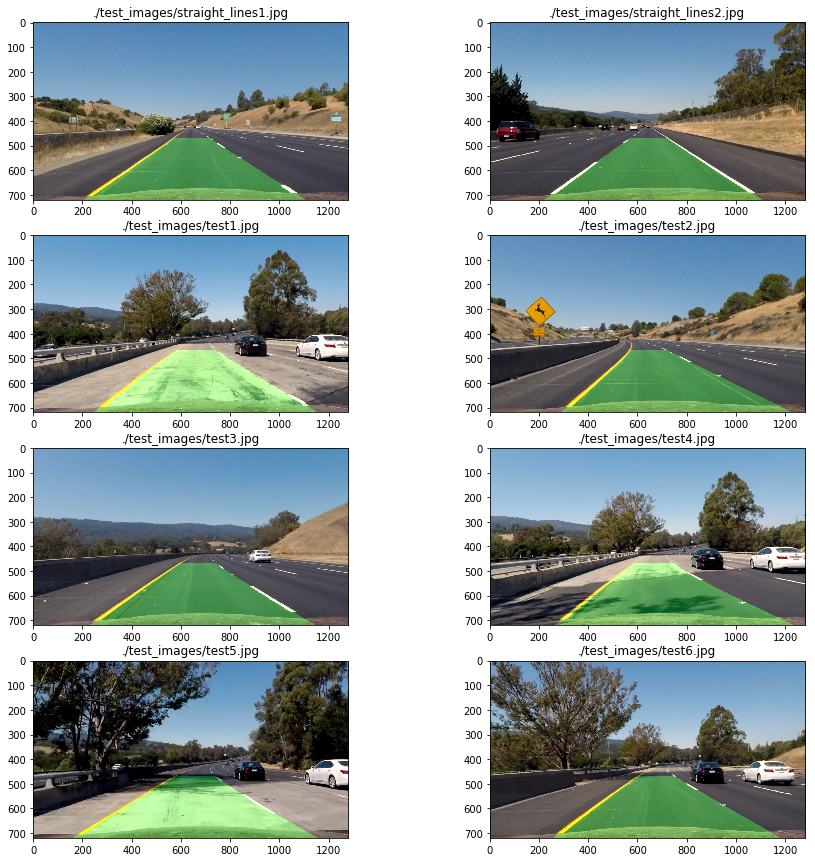

In [30]:
unwarp_images = list(map(lambda iImg: (iImg[1][0], unwarp(iImg[1][1], left_fits[iImg[0]], right_fits[iImg[0]])), enumerate(undistort_images)))

showImages(unwarp_images)

# Measuring ROC and offset from centre

In [31]:
# Define conversions in x and y from pixels space to meters
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension

In [32]:
def calculate_curvature(binary_warped, line_fit):
    
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    line_fitx = line_fit[0]*ploty**2 + line_fit[1]*ploty + line_fit[2]
    
    y_eval = np.max(ploty)
    
    # Fit new polynomials to x,y in world space
    line_fit_cr = np.polyfit(ploty*ym_per_pix, line_fitx*xm_per_pix, 2)
    
    # Calculate the R_curve (radius of curvature)
    cal_rcurve = ((1 + (2*line_fit_cr[0]*y_eval*ym_per_pix + line_fit_cr[1])**2)**1.5) / np.absolute(2*line_fit_cr[0])
    
    # Calculate line position offset to center
    p_line = np.poly1d(line_fit)
    line_fitx_1 = p_line(y_eval)
    
    center_offset = (line_fitx_1 - binary_warped.shape[1]/2)*xm_per_pix
    
    return cal_rcurve, center_offset

## Project the lane curvature onto our final output image

In [33]:
def draw_estimation(img, left_fit, right_fit):
    img_cp = img.copy()
    if left_fit.any() != None and right_fit.any() != None:
        left_cur, left_center_offest = calculate_curvature(img_cp, left_fit)
        right_cur, right_center_offest = calculate_curvature(img_cp, right_fit)

        center_offest = (left_center_offest + right_center_offest)/2.0
        if center_offest < 0:
            text = 'left'
        else:
            text = 'right'

        cv2.putText(img_cp,'left curvature:{:.2f}m'.format(left_cur),(10,60),cv2.FONT_HERSHEY_SIMPLEX,2,(255,255,255),3)
        cv2.putText(img_cp,'right curvature:{:.2f}m'.format(right_cur),(10,130),cv2.FONT_HERSHEY_SIMPLEX,2,(255,255,255),3)
        cv2.putText(img_cp,'Distance From Center: %.2fm %s' % (np.absolute(center_offest), text),(10,200), cv2.FONT_HERSHEY_SIMPLEX, 2,(255,255,255),3)
    
    return img_cp

# Test a sample image

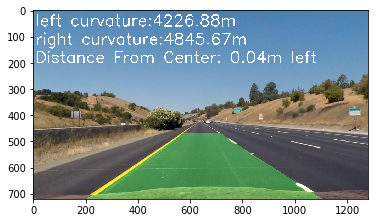

In [34]:
plt.imshow(draw_estimation(cv2.cvtColor(unwarp_images[0][1], cv2.COLOR_BGR2RGB), left_fits[0], right_fits[0]))

# Storing outputs in Output folder

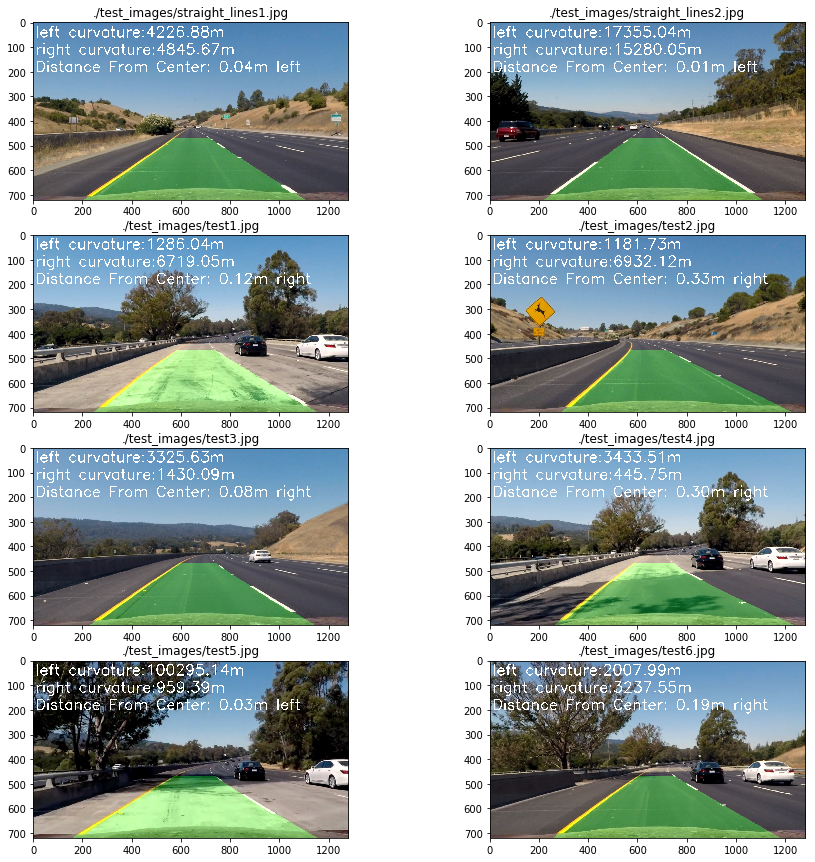

In [35]:
res_images = list(map(lambda iImg: (iImg[1][0], draw_estimation(iImg[1][1], left_fits[iImg[0]], right_fits[iImg[0]])), enumerate(unwarp_images)))

# write camera calibration images
outFolder = 'output_images/'

for i, image in enumerate(unwarp_images):
    imagePath, img = image
    final_image = draw_estimation(img, left_fits[i], right_fits[i])
    imgName = imagePath.split('.')[1].split('/')[2]+'_output.jpg' 
    outFile = '%s/%s' % (outFolder, imgName)
    cv2.imwrite(outFile, final_image)

showImages(res_images)